In [2]:
def parse_mdvrp_file(file_path):
    """
    Parsea un archivo de instancia MDVRP y devuelve un diccionario estructurado con los datos.
    """
    data = {
        'problem_type': None,
        'num_vehicles': None,
        'num_customers': None,
        'num_depots': None,
        'depots': [],
        'customers': [],
        'vehicle_info': []
    }

    with open(file_path, 'r') as file:
        lines = [line.strip() for line in file.readlines() if line.strip()]
        
        # Procesar primera línea (tipo, m, n, t)
        first_line = lines[0].split()
        data['problem_type'] = int(first_line[0])
        data['num_vehicles'] = int(first_line[1])
        data['num_customers'] = int(first_line[2])
        data['num_depots'] = int(first_line[3])
        
        # Procesar información de vehículos/depósitos (próximas t líneas)
        for i in range(1, data['num_depots'] + 1):
            if i >= len(lines):
                break
            D, Q = map(int, lines[i].split())
            data['vehicle_info'].append({
                'max_duration': D,
                'max_load': Q,
                'depot_coords': None  # Se llenará después si hay información de depósitos
            })
        
        # Procesar clientes (el resto de líneas)
        customer_start = data['num_depots'] + 1
        for line in lines[customer_start:]:
            parts = line.split()
            if len(parts) < 6:  # Posiblemente líneas de depósitos al final
                continue
                
            customer = {
                'id': int(parts[0]),
                'x': int(parts[1]),
                'y': int(parts[2]),
                'service_duration': int(parts[3]),
                'demand': int(parts[4]),
                'frequency': int(parts[5]),
                'num_visit_combinations': int(parts[6]),
                'visit_combinations': list(map(int, parts[7:7+int(parts[6])])),
                'time_window': (int(parts[-2]), int(parts[-1])) if len(parts) > 7+int(parts[6]) else None
            }
            data['customers'].append(customer)
        
        # En algunos archivos, los depósitos vienen después de los clientes
        # Buscamos líneas con demanda 0 que podrían ser depósitos
        for customer in data['customers']:
            if customer['demand'] == 0 and customer['frequency'] == 0:
                data['depots'].append({
                    'id': customer['id'],
                    'x': customer['x'],
                    'y': customer['y']
                })
        
        # Eliminar depósitos de la lista de clientes
        data['customers'] = [c for c in data['customers'] if c['demand'] > 0]
    
    return data

# Ejemplo de uso
file_path = 'p01.txt'  # Reemplaza con la ruta correcta
mdvrp_data = parse_mdvrp_file(file_path)

# Mostrar la estructura de los datos
print("Tipo de problema:", mdvrp_data['problem_type'])
print("Número de vehículos:", mdvrp_data['num_vehicles'])
print("Número de clientes:", mdvrp_data['num_customers'])
print("Número de depósitos:", mdvrp_data['num_depots'])
print("\nInformación de vehículos:")
for i, vehicle in enumerate(mdvrp_data['vehicle_info'], 1):
    print(f"  Vehículo {i}: Duración máxima={vehicle['max_duration']}, Carga máxima={vehicle['max_load']}")
print("\nDepósitos:")
for depot in mdvrp_data['depots']:
    print(f"  Depósito {depot['id']}: ({depot['x']}, {depot['y']})")
print("\nPrimeros 3 clientes:")
for customer in mdvrp_data['customers'][:3]:
    print(f"  Cliente {customer['id']}: Pos=({customer['x']}, {customer['y']}), Demanda={customer['demand']}, Ventana={customer['time_window']}")

Tipo de problema: 2
Número de vehículos: 4
Número de clientes: 50
Número de depósitos: 4

Información de vehículos:
  Vehículo 1: Duración máxima=0, Carga máxima=80
  Vehículo 2: Duración máxima=0, Carga máxima=80
  Vehículo 3: Duración máxima=0, Carga máxima=80
  Vehículo 4: Duración máxima=0, Carga máxima=80

Depósitos:
  Depósito 51: (20, 20)
  Depósito 52: (30, 40)
  Depósito 53: (50, 30)
  Depósito 54: (60, 50)

Primeros 3 clientes:
  Cliente 1: Pos=(37, 52), Demanda=7, Ventana=None
  Cliente 2: Pos=(49, 49), Demanda=30, Ventana=None
  Cliente 3: Pos=(52, 64), Demanda=16, Ventana=None


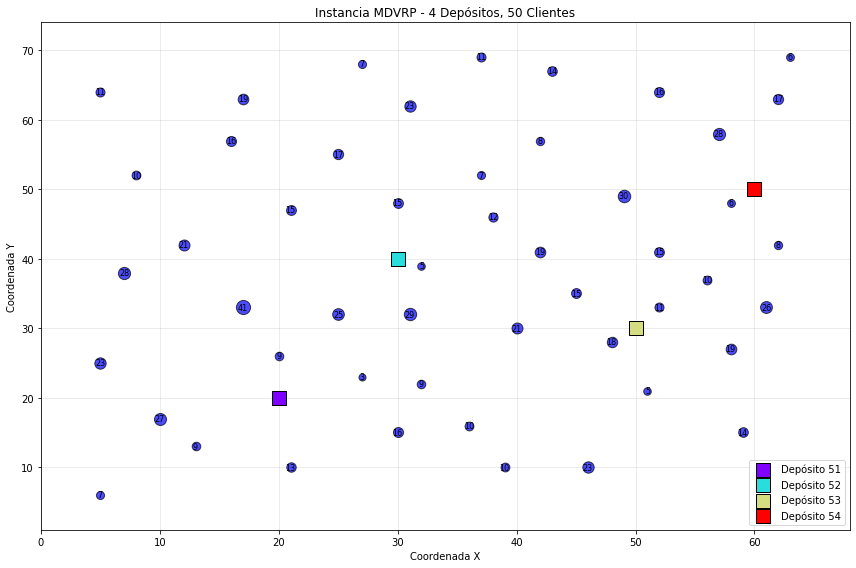

In [4]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

def plot_mdvrp_instance(data, show_demand=True, show_time_windows=False):
    """
    Visualiza una instancia MDVRP mostrando depósitos, clientes y demandas.
    
    Parámetros:
    - data: Diccionario con los datos parseados
    - show_demand: Si True, muestra el tamaño de los puntos según la demanda
    - show_time_windows: Si True, muestra información de ventanas de tiempo
    """
    plt.figure(figsize=(12, 8))
    
    # Configuración de colores
    depot_color = 'red'
    customer_color = 'blue'
    colors = cm.rainbow(np.linspace(0, 1, len(data['depots'])))
    
    # Dibujar depósitos
    for i, depot in enumerate(data['depots']):
        plt.scatter(depot['x'], depot['y'], 
                   c=[colors[i]], 
                   s=200, marker='s', 
                   edgecolors='black',
                   label=f'Depósito {depot["id"]}',
                   zorder=5)
    
    # Dibujar clientes
    demands = [c['demand'] for c in data['customers']]
    min_demand, max_demand = min(demands), max(demands)
    
    for customer in data['customers']:
        size = 50 + 150 * (customer['demand'] - min_demand) / (max_demand - min_demand) if show_demand else 50
        plt.scatter(customer['x'], customer['y'], 
                   c=customer_color, 
                   s=size, 
                   alpha=0.7,
                   edgecolors='black',
                   zorder=3)
        
        # Mostrar demanda como texto
        if show_demand:
            plt.text(customer['x'], customer['y'], 
                    str(customer['demand']), 
                    fontsize=8, ha='center', va='center')
        
        # Mostrar ventanas de tiempo si está activado
        if show_time_windows and customer['time_window']:
            e, l = customer['time_window']
            plt.text(customer['x'], customer['y']-2, 
                    f'[{e}-{l}]', 
                    fontsize=7, ha='center', va='top', color='green')
    
    # Añadir detalles del gráfico
    plt.title(f'Instancia MDVRP - {len(data["depots"])} Depósitos, {len(data["customers"])} Clientes')
    plt.xlabel('Coordenada X')
    plt.ylabel('Coordenada Y')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Ajustar el zoom para ver todos los puntos
    all_x = [d['x'] for d in data['depots']] + [c['x'] for c in data['customers']]
    all_y = [d['y'] for d in data['depots']] + [c['y'] for c in data['customers']]
    plt.xlim(min(all_x)-5, max(all_x)+5)
    plt.ylim(min(all_y)-5, max(all_y)+5)
    
    plt.tight_layout()
    plt.show()

# Ejemplo de uso con los datos parseados anteriormente
file_path = 'p01.txt'  # Asegúrate de tener el archivo en tu directorio
mdvrp_data = parse_mdvrp_file(file_path)  # Usando la función de parsing anterior

# Visualización básica
plot_mdvrp_instance(mdvrp_data, show_demand=True, show_time_windows=False)

# Visualización con ventanas de tiempo
# plot_mdvrp_instance(mdvrp_data, show_demand=True, show_time_windows=True)


In [6]:
def plot_mdvrp_solution(data, routes):
    """Visualiza una solución con rutas asignadas"""
    plot_mdvrp_instance(data, show_demand=False)  # Dibuja la base primero
    
    # Colores para las rutas
    colors = cm.rainbow(np.linspace(0, 1, len(routes)))
    
    for i, route in enumerate(routes):
        # Conectar puntos de la ruta
        x_coords = []
        y_coords = []
        
        # Comenzar desde el depósito
        depot = data['depots'][route['depot_id']]
        x_coords.append(depot['x'])
        y_coords.append(depot['y'])
        
        # Añadir clientes
        for cust_id in route['customers']:
            customer = next(c for c in data['customers'] if c['id'] == cust_id)
            x_coords.append(customer['x'])
            y_coords.append(customer['y'])
        
        # Regresar al depósito
        x_coords.append(depot['x'])
        y_coords.append(depot['y'])
        
        # Dibujar la ruta
        plt.plot(x_coords, y_coords, 
                color=colors[i], 
                linestyle='-', 
                linewidth=2,
                marker='o',
                markersize=6,
                label=f'Ruta {i+1} (Veh {route["vehicle_id"]})',
                alpha=0.7)
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title('Solución MDVRP con Rutas Asignadas')
    plt.tight_layout()
    plt.show()

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

class BRKGA_MDVRP:
    def __init__(self, data, population_size=100, elite_percent=0.2, mutants_percent=0.1):
        """
        Inicializa el BRKGA para MDVRP
        
        Args:
            data: Diccionario con los datos del problema
            population_size: Tamaño de la población
            elite_percent: Porcentaje de individuos élite
            mutants_percent: Porcentaje de mutantes
        """
        self.data = data
        self.population_size = population_size
        self.elite_size = int(population_size * elite_percent)
        self.mutants_size = int(population_size * mutants_percent)
        self.num_depots = len(data['depots'])
        
        # Número de genes: 2 genes por cliente (asignación + orden)
        self.num_genes = 2 * len(data['customers'])
        
        # Parámetros de decodificación
        self.p_bias = 0.7  # Probabilidad de tomar gen del padre élite
        
    def initialize_population(self):
        """Inicializa la población aleatoriamente"""
        return np.random.rand(self.population_size, self.num_genes)
    
    def decode(self, chromosome):
        """
        Decodifica un cromosoma en una solución factible
        
        Returns:
            solution: Lista de rutas por depósito
            total_distance: Distancia total de la solución
        """
        num_customers = len(self.data['customers'])
        
        # 1. Asignar clientes a depósitos (usando todos los depósitos disponibles)
        depot_assignments = []
        for i in range(num_customers):
            # Dividir el rango [0,1] en partes iguales para cada depósito
            depot_idx = int(chromosome[i] * self.num_depots)
            depot_idx = min(depot_idx, self.num_depots-1)  # Asegurar que no exceda
            depot_assignments.append(depot_idx)
        
        # 2. Ordenar clientes dentro de cada depósito
        sorted_indices = np.argsort(chromosome[num_customers:])
        
        # 3. Construir rutas iniciales (agrupando por depósito)
        routes = {depot['id']: [] for depot in self.data['depots']}
        for idx in sorted_indices:
            depot_id = self.data['depots'][depot_assignments[idx]]['id']
            customer_id = self.data['customers'][idx]['id']
            routes[depot_id].append(customer_id)
        
        # 4. Dividir en rutas factibles (considerando capacidad)
        feasible_routes = []
        total_distance = 0
        
        for depot_id, customers in routes.items():
            depot = next(d for d in self.data['depots'] if d['id'] == depot_id)
            current_route = []
            current_load = 0
            current_duration = 0
            
            for cust_id in customers:
                customer = next(c for c in self.data['customers'] if c['id'] == cust_id)
                
                # Verificar restricciones de capacidad y duración
                if (current_load + customer['demand'] > self.data['vehicle_info'][0]['max_load'] or
                    current_duration + customer['service_duration'] > self.data['vehicle_info'][0]['max_duration']):
                    # Cerrar la ruta actual y comenzar una nueva
                    if current_route:
                        route_distance = self.calculate_route_distance(depot, current_route)
                        feasible_routes.append({
                            'depot_id': depot_id,
                            'customers': current_route,
                            'load': current_load,
                            'distance': route_distance
                        })
                        total_distance += route_distance
                    
                    current_route = []
                    current_load = 0
                    current_duration = 0
                
                current_route.append(cust_id)
                current_load += customer['demand']
                current_duration += customer['service_duration']
            
            # Añadir la última ruta del depósito
            if current_route:
                route_distance = self.calculate_route_distance(depot, current_route)
                feasible_routes.append({
                    'depot_id': depot_id,
                    'customers': current_route,
                    'load': current_load,
                    'distance': route_distance
                })
                total_distance += route_distance
        
        return feasible_routes, total_distance
    
    def calculate_route_distance(self, depot, customers):
        """Calcula la distancia total de una ruta"""
        if not customers:
            return 0
        
        # Coordenadas del depósito
        depot_x, depot_y = depot['x'], depot['y']
        
        # Obtener coordenadas de todos los puntos en la ruta
        points = [(depot_x, depot_y)]  # Comienza en el depósito
        for cust_id in customers:
            customer = next(c for c in self.data['customers'] if c['id'] == cust_id)
            points.append((customer['x'], customer['y']))
        points.append((depot_x, depot_y))  # Regresa al depósito
        
        # Calcular distancia euclidiana acumulada
        distance = 0
        for i in range(len(points)-1):
            x1, y1 = points[i]
            x2, y2 = points[i+1]
            distance += np.sqrt((x2-x1)**2 + (y2-y1)**2)
        
        return distance
    
    def fitness(self, chromosome):
        """Evalúa la calidad de un cromosoma"""
        solution, total_distance = self.decode(chromosome)
        
        # Penalización por no usar todos los depósitos
        used_depots = set(route['depot_id'] for route in solution)
        penalty = 0
        if len(used_depots) < self.num_depots:
            penalty = 1000 * (self.num_depots - len(used_depots))
        
        return total_distance + penalty
    
    def crossover(self, elite_parent, non_elite_parent):
        """Operador de cruce sesgado"""
        child = np.where(np.random.rand(self.num_genes) < self.p_bias, 
                         elite_parent, non_elite_parent)
        return child
    
    def evolve(self, population, fitness_values):
        """Evoluciona la población a la siguiente generación"""
        # Ordenar la población por fitness
        sorted_indices = np.argsort(fitness_values)
        elite = population[sorted_indices[:self.elite_size]]
        non_elite = population[sorted_indices[self.elite_size:]]
        
        # Generar descendencia
        offspring = []
        for _ in range(self.population_size - self.elite_size - self.mutants_size):
            elite_parent = elite[np.random.randint(self.elite_size)]
            non_elite_parent = non_elite[np.random.randint(len(non_elite))]
            offspring.append(self.crossover(elite_parent, non_elite_parent))
        
        # Crear mutantes
        mutants = np.random.rand(self.mutants_size, self.num_genes)
        
        # Nueva población = élite + descendencia + mutantes
        new_population = np.vstack([elite, offspring, mutants])
        
        return new_population
    
    def solve(self, generations=100, verbose=True):
        """Ejecuta el algoritmo BRKGA"""
        # Inicialización
        population = self.initialize_population()
        best_solution = None
        best_fitness = float('inf')
        fitness_history = []
        
        for gen in range(generations):
            # Evaluar población
            fitness_values = np.array([self.fitness(ind) for ind in population])
            
            # Actualizar mejor solución
            current_best_idx = np.argmin(fitness_values)
            current_fitness = fitness_values[current_best_idx]
            
            if current_fitness < best_fitness:
                best_fitness = current_fitness
                best_solution, _ = self.decode(population[current_best_idx])
            
            fitness_history.append(best_fitness)
            
            if verbose and gen % 10 == 0:
                print(f"Generación {gen}: Mejor fitness = {best_fitness:.2f}")
            
            # Evolucionar población
            population = self.evolve(population, fitness_values)
        
        # Decodificar la mejor solución encontrada (sin penalización)
        best_solution, best_distance = self.decode(population[np.argmin(fitness_values)])
        
        if verbose:
            print("\nMejor solución encontrada:")
            used_depots = set()
            for i, route in enumerate(best_solution):
                print(f"Ruta {i+1} (Depósito {route['depot_id']}): {route['customers']}")
                print(f"  Distancia: {route['distance']:.2f}, Carga: {route['load']}")
                used_depots.add(route['depot_id'])
            print(f"Distancia total: {best_distance:.2f}")
            print(f"Depósitos utilizados: {len(used_depots)}/{self.num_depots}")
        
        return best_solution, best_distance, fitness_history



Generación 0: Mejor fitness = 1632.87
Generación 10: Mejor fitness = 1311.09
Generación 20: Mejor fitness = 1023.69
Generación 30: Mejor fitness = 830.52
Generación 40: Mejor fitness = 716.64

Mejor solución encontrada:
Ruta 1 (Depósito 51): [4, 18, 25]
  Distancia: 47.00, Carga: 78
Ruta 2 (Depósito 51): [13, 41, 19, 40, 42]
  Distancia: 67.42, Carga: 79
Ruta 3 (Depósito 51): [17, 37, 44]
  Distancia: 31.18, Carga: 28
Ruta 4 (Depósito 52): [14, 43, 24, 23, 48]
  Distancia: 88.03, Carga: 75
Ruta 5 (Depósito 52): [6, 26, 7, 32, 27, 1]
  Distancia: 101.64, Carga: 75
Ruta 6 (Depósito 52): [12, 47, 46]
  Distancia: 26.20, Carga: 59
Ruta 7 (Depósito 53): [9, 39, 30, 50, 16]
  Distancia: 62.00, Carga: 69
Ruta 8 (Depósito 53): [34, 49, 11]
  Distancia: 53.25, Carga: 63
Ruta 9 (Depósito 53): [5, 38, 15, 45, 33]
  Distancia: 72.20, Carga: 79
Ruta 10 (Depósito 53): [10]
  Distancia: 18.11, Carga: 5
Ruta 11 (Depósito 54): [22, 8, 31, 28, 3]
  Distancia: 72.55, Carga: 72
Ruta 12 (Depósito 54): [20,

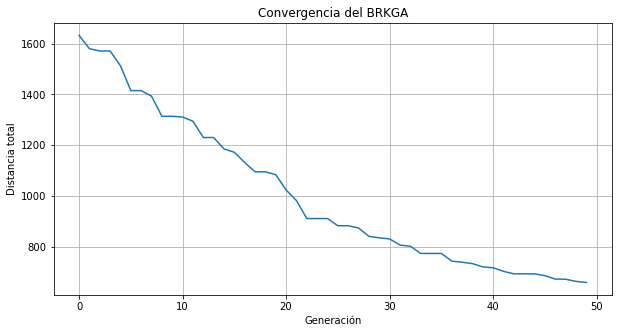

In [21]:
# Cargar los datos del problema
file_path = 'p01.txt'
mdvrp_data = parse_mdvrp_file(file_path)

# Crear y ejecutar el BRKGA
brkga = BRKGA_MDVRP(mdvrp_data, population_size=1000, elite_percent=0.1, mutants_percent=0.1)
best_solution, best_distance, fitness_history = brkga.solve(generations=50)

# Visualizar la convergencia
plt.figure(figsize=(10, 5))
plt.plot(fitness_history)
plt.title('Convergencia del BRKGA')
plt.xlabel('Generación')
plt.ylabel('Distancia total')
plt.grid(True)
plt.show()

In [17]:
def visualize_routes(data, routes, show_demand=True, show_route_info=True):
    """
    Visualiza las rutas de la solución MDVRP
    
    Args:
        data: Diccionario con los datos del problema
        routes: Lista de rutas obtenidas de la solución BRKGA
        show_demand: Muestra el tamaño de los puntos según la demanda
        show_route_info: Muestra información sobre cada ruta
    """
    plt.figure(figsize=(14, 10))
    
    # Configuración de colores
    depot_color = 'red'
    customer_color = 'blue'
    colors = plt.cm.rainbow(np.linspace(0, 1, len(routes)))
    
    # Dibujar depósitos
    for depot in data['depots']:
        plt.scatter(depot['x'], depot['y'], 
                   c=depot_color, 
                   s=300, marker='s', 
                   edgecolors='black',
                   linewidths=2,
                   label='Depósito' if depot == data['depots'][0] else "",
                   zorder=5)
    
    # Dibujar clientes (todos primero)
    demands = [c['demand'] for c in data['customers']]
    min_demand, max_demand = min(demands), max(demands)
    
    for customer in data['customers']:
        size = 50 + 150 * (customer['demand'] - min_demand) / (max_demand - min_demand) if show_demand else 50
        plt.scatter(customer['x'], customer['y'], 
                   c=customer_color, 
                   s=size, 
                   alpha=0.7,
                   edgecolors='black',
                   zorder=3)
        
        if show_demand:
            plt.text(customer['x'], customer['y'], 
                    str(customer['demand']), 
                    fontsize=9, ha='center', va='center', color='white')
    
    # Dibujar las rutas
    for i, route in enumerate(routes):
        # Obtener coordenadas de todos los puntos en la ruta
        depot = next(d for d in data['depots'] if d['id'] == route['depot_id'])
        points = [(depot['x'], depot['y'])]
        
        for cust_id in route['customers']:
            customer = next(c for c in data['customers'] if c['id'] == cust_id)
            points.append((customer['x'], customer['y']))
        
        points.append((depot['x'], depot['y']))  # Regreso al depósito
        
        # Separar coordenadas X e Y
        x_coords = [p[0] for p in points]
        y_coords = [p[1] for p in points]
        
        # Dibujar la ruta
        plt.plot(x_coords, y_coords, 
                color=colors[i], 
                linestyle='-', 
                linewidth=2.5,
                marker='o',
                markersize=8 if show_route_info else 6,
                markerfacecolor='white' if show_route_info else colors[i],
                markeredgecolor=colors[i],
                markeredgewidth=1,
                alpha=0.9,
                label=f'Ruta {i+1}: {len(route["customers"])} clientes, Dist: {route["distance"]:.1f}',
                zorder=4)
        
        # Marcar el orden de visita
        if show_route_info:
            for j in range(1, len(points)-1):
                plt.text(points[j][0], points[j][1], 
                        str(j), 
                        fontsize=8, ha='center', va='center', 
                        color='black', weight='bold')
    
    # Añadir detalles del gráfico
    plt.title('Solución MDVRP - Visualización de Rutas', fontsize=14, pad=20)
    plt.xlabel('Coordenada X', fontsize=12)
    plt.ylabel('Coordenada Y', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Leyenda mejorada
    legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    legend.set_title('Leyenda', prop={'size': 11, 'weight': 'bold'})
    
    # Ajustar el zoom para ver todos los puntos
    all_x = [d['x'] for d in data['depots']] + [c['x'] for c in data['customers']]
    all_y = [d['y'] for d in data['depots']] + [c['y'] for c in data['customers']]
    plt.xlim(min(all_x)-10, max(all_x)+10)
    plt.ylim(min(all_y)-10, max(all_y)+10)
    
    # Añadir información general
    plt.figtext(0.5, 0.01, 
                f"Total Rutas: {len(routes)} | Distancia Total: {sum(r['distance'] for r in routes):.1f} | " +
                f"Clientes Atendidos: {sum(len(r['customers']) for r in routes)}/{len(data['customers'])}", 
                ha="center", fontsize=11, bbox={"facecolor":"orange", "alpha":0.3, "pad":5})
    
    plt.tight_layout()
    plt.show()

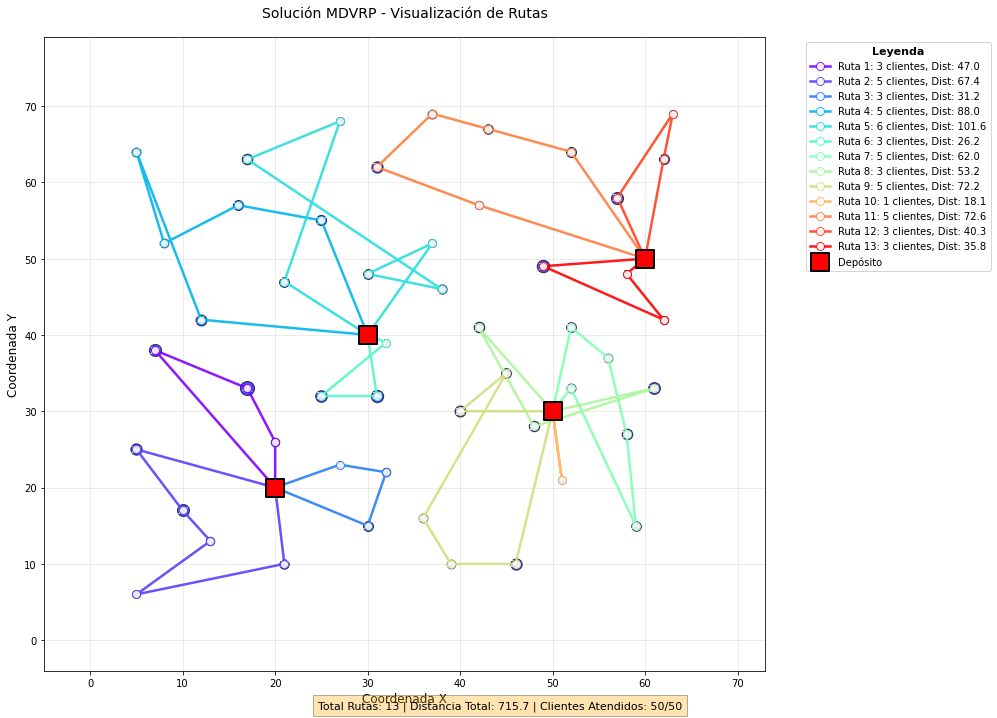

In [22]:
# Ejemplo de uso con la solución obtenida del BRKGA
visualize_routes(mdvrp_data, best_solution, show_demand=True, show_route_info=True)

In [25]:
def debug_solution(data, routes, verbose=True):
    """
    Verifica que una solución cumpla con todas las restricciones del MDVRP
    
    Args:
        data: Diccionario con los datos del problema
        routes: Lista de rutas de la solución a verificar
        verbose: Si True, muestra detalles de las verificaciones
    
    Returns:
        Tuple: (is_valid, violations) donde:
            is_valid: Booleano indicando si la solución es válida
            violations: Diccionario con el conteo de violaciones por tipo
    """
    violations = {
        'capacity': 0,
        'duration': 0,
        'unserved_customers': 0,
        'duplicate_customers': 0,
        'wrong_depot': 0,
        'time_windows': 0
    }
    
    # 1. Verificar que todos los clientes sean atendidos exactamente una vez
    served_customers = []
    for route in routes:
        served_customers.extend(route['customers'])
    
    all_customer_ids = [c['id'] for c in data['customers']]
    
    # Clientes no atendidos
    unserved = set(all_customer_ids) - set(served_customers)
    violations['unserved_customers'] = len(unserved)
    
    # Clientes duplicados
    duplicate_customers = [cid for cid in served_customers if served_customers.count(cid) > 1]
    violations['duplicate_customers'] = len(set(duplicate_customers))
    
    # 2. Verificar restricciones por ruta
    for i, route in enumerate(routes):
        if verbose:
            print(f"\nVerificando Ruta {i+1} (Depósito {route['depot_id']}):")
        
        # Obtener depósito correspondiente
        try:
            depot = next(d for d in data['depots'] if d['id'] == route['depot_id'])
        except StopIteration:
            if verbose:
                print(f"  ❌ ERROR: Depósito {route['depot_id']} no existe")
            violations['wrong_depot'] += 1
            continue
        
        # Calcular carga total y duración
        total_load = 0
        total_duration = 0
        current_time = 0  # Para verificación de ventanas de tiempo
        
        # Coordenadas iniciales (depósito)
        prev_x, prev_y = depot['x'], depot['y']
        
        for j, cust_id in enumerate(route['customers']):
            try:
                customer = next(c for c in data['customers'] if c['id'] == cust_id)
            except StopIteration:
                if verbose:
                    print(f"  ❌ ERROR: Cliente {cust_id} no existe")
                continue
            
            # Verificar carga
            total_load += customer['demand']
            
            # Calcular tiempo de viaje al cliente
            distance = np.sqrt((customer['x']-prev_x)**2 + (customer['y']-prev_y)**2)
            current_time += distance  # Tiempo de viaje
            
            # Verificar ventana de tiempo
            if customer['time_window']:
                e, l = customer['time_window']
                if current_time < e:
                    # Esperar hasta el inicio de la ventana
                    current_time = e
                elif current_time > l:
                    if verbose:
                        print(f"  ❌ Violación de ventana de tiempo en cliente {cust_id}: "
                              f"Llegada {current_time:.2f} > Fin {l}")
                    violations['time_windows'] += 1
            
            # Tiempo de servicio
            current_time += customer['service_duration']
            total_duration += distance + customer['service_duration']
            
            # Actualizar coordenadas para el siguiente cálculo
            prev_x, prev_y = customer['x'], customer['y']
        
        # Añadir el regreso al depósito
        distance_to_depot = np.sqrt((depot['x']-prev_x)**2 + (depot['y']-prev_y)**2)
        total_duration += distance_to_depot
        
        # Verificar capacidad máxima
        if total_load > data['vehicle_info'][0]['max_load']:
            if verbose:
                print(f"  ❌ Violación de capacidad: {total_load} > {data['vehicle_info'][0]['max_load']}")
            violations['capacity'] += 1
        
        # Verificar duración máxima
        if total_duration > data['vehicle_info'][0]['max_duration']:
            if verbose:
                print(f"  ❌ Violación de duración: {total_duration:.2f} > {data['vehicle_info'][0]['max_duration']}")
            violations['duration'] += 1
        
        if verbose:
            print(f"  ✔ Carga: {total_load}/{data['vehicle_info'][0]['max_load']}")
            print(f"  ✔ Duración: {total_duration:.2f}/{data['vehicle_info'][0]['max_duration']}")
    
    # 3. Resumen de verificaciones
    is_valid = all(v == 0 for v in violations.values())
    
    if verbose:
        print("\n" + "="*50)
        print(" RESUMEN DE VERIFICACIÓN:")
        print(f" - Clientes no atendidos: {violations['unserved_customers']}")
        print(f" - Clientes duplicados: {violations['duplicate_customers']}")
        print(f" - Rutas con depósito incorrecto: {violations['wrong_depot']}")
        print(f" - Violaciones de capacidad: {violations['capacity']}")
        print(f" - Violaciones de duración: {violations['duration']}")
        print(f" - Violaciones de ventanas de tiempo: {violations['time_windows']}")
        print("\n" + "="*50)
        print(f"SOLUCIÓN {'VÁLIDA' if is_valid else 'NO VÁLIDA'}")
        print("="*50)
    
    return is_valid, violations

# Ejemplo de uso:
is_valid, violations = debug_solution(mdvrp_data, best_solution, verbose=True)


Verificando Ruta 1 (Depósito 51):
  ❌ Violación de duración: 47.00 > 0
  ✔ Carga: 78/80
  ✔ Duración: 47.00/0

Verificando Ruta 2 (Depósito 51):
  ❌ Violación de duración: 67.42 > 0
  ✔ Carga: 79/80
  ✔ Duración: 67.42/0

Verificando Ruta 3 (Depósito 51):
  ❌ Violación de duración: 31.18 > 0
  ✔ Carga: 28/80
  ✔ Duración: 31.18/0

Verificando Ruta 4 (Depósito 52):
  ❌ Violación de duración: 88.03 > 0
  ✔ Carga: 75/80
  ✔ Duración: 88.03/0

Verificando Ruta 5 (Depósito 52):
  ❌ Violación de duración: 101.64 > 0
  ✔ Carga: 75/80
  ✔ Duración: 101.64/0

Verificando Ruta 6 (Depósito 52):
  ❌ Violación de duración: 26.20 > 0
  ✔ Carga: 59/80
  ✔ Duración: 26.20/0

Verificando Ruta 7 (Depósito 53):
  ❌ Violación de duración: 62.00 > 0
  ✔ Carga: 69/80
  ✔ Duración: 62.00/0

Verificando Ruta 8 (Depósito 53):
  ❌ Violación de duración: 53.25 > 0
  ✔ Carga: 63/80
  ✔ Duración: 53.25/0

Verificando Ruta 9 (Depósito 53):
  ❌ Violación de duración: 72.20 > 0
  ✔ Carga: 79/80
  ✔ Duración: 72.20/0